# 🎯 Διευκρίνιση Στόχου

## Τι Ανακαλύπτουμε;
**Ποια patterns διευθύνσεων καταλαβαίνει καλύτερα το Google Maps API για πιο ακριβές geocoding**

### Παράδειγμα:
- **Original**: "Π.Ε.Ο. Αθηνών-Θεσσαλονίκης 15ο ΧΛΜ" → Google: 1200m απόσταση
- **Cleaned**: "Αθηνών Θεσσαλονίκης 15 Km" → Google: 450m απόσταση ✅

### Ερώτημα ML:
*"Με βάση τα χαρακτηριστικά της διεύθυνσης, ποιο cleaning pattern θα καταλάβει καλύτερα το Google API;"*

---

# Geocoding Pattern Analysis με Machine Learning

## Περιγραφή
Αυτό το notebook αναλύει **19 διαφορετικές μεθόδους καθαρισμού διευθύνσεων** για βενζινάδικα και χρησιμοποιεί **Machine Learning** για να προβλέπει την καλύτερη μέθοδο ανά περίπτωση.

## Βήματα Ανάλυσης
1. **Φόρτωση δεδομένων** και ορισμός μεθόδων καθαρισμού
2. **Geocoding experiments** με Google Maps API  
3. **Υπολογισμός καλύτερης μεθόδου** ανά σταθμό
4. **Feature extraction** από διευθύνσεις
5. **Machine Learning** με Random Forest
6. **Ανάλυση αποτελεσμάτων** και visualizations

## Αρχεία Εξόδου
- `geocoding_19methods_full.xlsx` - Raw αποτελέσματα
- `geocoding_summary.xlsx` - Στατιστικά ανά μέθοδο
- `geocoding_corrected_baseline.xlsx` - Βελτιωμένα results
- `rf_best_model.joblib` - Trained ML μοντέλο
- Άλλα: confusion matrix, feature importance, κλπ.

In [1]:
import os
from dotenv import load_dotenv
import googlemaps
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import time
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier  # *** CHANGED ***
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
import joblib  # for saving model (used later) - harmless add
import warnings
warnings.filterwarnings('ignore')

# Fortosi API key
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

if not GOOGLE_API_KEY:
    raise ValueError("Den vrethike to GOOGLE_MAPS_API_KEY sto .env file!")

print("API Key fortothike swsta")

gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

# Paths - ola ta arxeia ston geocoding_pattern_analysis_ml fakelo
BASE_OUTPUT_DIR = "/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml"
INPUT_FILE = "/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison_FULL.xlsx"
OUTPUT_RAW = os.path.join(BASE_OUTPUT_DIR, "geocoding_19methods_full.xlsx")
OUTPUT_SUMMARY = os.path.join(BASE_OUTPUT_DIR, "geocoding_summary.xlsx")
OUTPUT_CORRECTED = os.path.join(BASE_OUTPUT_DIR, "geocoding_corrected_baseline.xlsx")

# Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Configuration oloklirothike")
print(f"Output directory: {BASE_OUTPUT_DIR}")

API Key fortothike swsta
Configuration oloklirothike
Output directory: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml


In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Ypologismos apostasis se metra metaxy dyo simeion
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return None
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return c * 6371000


def extract_address_features(address):
    # Exagogi charakteristikon apo diefthinsi
    
    features = {}
    
    # Basic presence checks
    features['has_question_mark'] = 1 if '?' in address else 0
    features['has_peo'] = 1 if re.search(r'Π\.?Ε\.?Ο\.?|ΠΕΟ', address, re.IGNORECASE) else 0
    features['has_eo'] = 1 if re.search(r'Ε\.?Ο\.?|ΕΟ', address, re.IGNORECASE) else 0
    features['has_neo'] = 1 if re.search(r'Ν\.?Ε\.?Ο\.?|ΝΕΟ', address, re.IGNORECASE) else 0
    features['has_dash'] = 1 if '-' in address else 0
    features['has_comma'] = 1 if ',' in address else 0
    
    # KM notation
    if re.search(r'ΧΛΜ|χλμ', address):
        features['km_notation'] = 0
    elif re.search(r'Km|km|ΚΜ', address):
        features['km_notation'] = 1
    else:
        features['km_notation'] = 2
    
    # Arithmos poleon
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    keywords = {'ΧΛΜ', 'Km', 'ΠΕΟ', 'ΕΟ', 'ΝΕΟ', 'ΟΔΟΣ', 'ΕΘΝΙΚΗΣ'}
    cities = [c for c in cities if c.upper() not in keywords]
    features['num_cities'] = len(cities)
    
    # Thesi KM
    km_match = re.search(r'(\d+)[οηόήOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, re.IGNORECASE)
    if km_match:
        km_position = address.find(km_match.group(0))
        if km_position < len(address) * 0.3:
            features['km_position'] = 0  # start
        elif km_position > len(address) * 0.7:
            features['km_position'] = 2  # end
        else:
            features['km_position'] = 1  # middle
    else:
        features['km_position'] = 3  # no km
    
    # Ordinal numbers
    features['has_ordinal'] = 1 if re.search(r'\d+[οηόήOH]', address) else 0
    
    # Mikos
    features['address_length'] = len(address)
    features['num_words'] = len(address.split())
    features['num_dots'] = address.count('.')
    
    # Archi me arithmo
    features['starts_with_digit'] = 1 if address.strip()[0].isdigit() else 0
    
    return features


print("Helper functions oristikan")

Helper functions oristikan


In [3]:
def clean_v1_original(address):
    # v1: Kamia allagi
    return address

def clean_v2_remove_prefix(address):
    # v2: Afairesi Π.Ε.Ο., Ε.Ο., Ν.Ε.Ο.
    address = re.sub(r'Π\.?\s?Ε\.?\s?Ο\.?', '', address, flags=re.IGNORECASE)
    address = re.sub(r'Ε\.?\s?Ο\.?', '', address, flags=re.IGNORECASE)
    address = re.sub(r'Ν\.?\s?Ε\.?\s?Ο\.?', '', address, flags=re.IGNORECASE)
    address = re.sub(r'ΠΕΟ|ΕΟ|ΝΕΟ', '', address, flags=re.IGNORECASE)
    return ' '.join(address.split())

def clean_v3_normalize_km(address):
    # v3: Kanonikopisi ΧΛΜ se Km
    address = re.sub(r'ΧΛΜ|χλμ|χιλ\.?|ΚΜ', 'Km', address, flags=re.IGNORECASE)
    address = re.sub(r'(\d+)[οηόήΟΗ]?\s+(Km|km)', r'\1 Km', address)
    return address

def clean_v4_remove_punct_v1(address):
    # v4: Afairesi - kai ,
    address = address.replace('-', ' ')
    address = address.replace(',', ' ')
    address = re.sub(r'\s+', ' ', address)
    return address.strip()

def clean_v5_remove_punct_v2(address):
    # v5: Afairesi -, ?, ,
    address = address.replace('-', ' ')
    address = address.replace('?', ' ')
    address = address.replace(',', ' ')
    address = re.sub(r'\s+', ' ', address)
    return address.strip()

def clean_v6_remove_dots(address):
    # v6: Afairesi teleton
    address = address.replace('Π.Ε.Ο.', 'ΠΕΟ')
    address = address.replace('Ε.Ο.', 'ΕΟ')
    address = address.replace('Ν.Ε.Ο.', 'ΝΕΟ')
    address = address.replace('.', '')
    return ' '.join(address.split())

def clean_v7_remove_all_punct(address):
    # v7: Afairesi olis tis stiksis
    address = re.sub(r'[.,;:\-\?!/()\[\]{}]', ' ', address)
    address = re.sub(r'\s+', ' ', address)
    return address.strip()

def clean_v8_combined_basic(address):
    # v8: Syndiasmos vasikon methodon
    address = clean_v2_remove_prefix(address)
    address = clean_v3_normalize_km(address)
    address = clean_v5_remove_punct_v2(address)
    return address

def clean_v9_combined_aggressive(address):
    # v9: Epithetikos katharismos
    address = clean_v2_remove_prefix(address)
    address = clean_v3_normalize_km(address)
    address = clean_v5_remove_punct_v2(address)
    address = clean_v6_remove_dots(address)
    return address

def clean_v10_add_eo_prefix(address):
    # v10: Prosthiki 'Ethniki Odos' sto prefix
    km_match = re.search(r'(\d+)[οηOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, flags=re.IGNORECASE)
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    
    if km_match and len(cities) >= 2:
        km_num = km_match.group(1)
        return f"Εθνική Οδός {cities[0]} {cities[1]} {km_num} χλμ"
    return address

def clean_v11_km_first(address):
    # v11: Km proto sti seira
    km_match = re.search(r'(\d+)[οηOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, flags=re.IGNORECASE)
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    
    if km_match and len(cities) >= 2:
        km_num = km_match.group(1)
        return f"{km_num} Km {cities[0]} {cities[1]}"
    
    return clean_v8_combined_basic(address)

def clean_v12_simplify_cities_only(address):
    # v12: Mono poleis
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    keywords = {'ΧΛΜ', 'Km', 'ΠΕΟ', 'ΕΟ', 'ΝΕΟ', 'ΟΔΟΣ', 'ΕΘΝΙΚΗΣ'}
    cities = [c for c in cities if c.upper() not in keywords]
    
    if len(cities) >= 2:
        return f"{cities[0]} {cities[1]}"
    elif len(cities) == 1:
        return cities[0]
    return address

def clean_v13_simplify_km_cities(address):
    # v13: Km kai poleis
    km_match = re.search(r'(\d+)[οηOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, flags=re.IGNORECASE)
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    keywords = {'ΧΛΜ', 'Km', 'ΠΕΟ', 'ΕΟ', 'ΝΕΟ', 'ΟΔΟΣ', 'ΕΘΝΙΚΗΣ'}
    cities = [c for c in cities if c.upper() not in keywords]
    
    if km_match and len(cities) >= 2:
        km_num = km_match.group(1)
        return f"{km_num} Km {cities[0]} {cities[1]}"
    return clean_v8_combined_basic(address)

def clean_v14_add_greece_suffix(address):
    # v14: Prosthiki Greece
    cleaned = clean_v8_combined_basic(address)
    return f"{cleaned}, Greece"

def clean_v15_add_highway_context(address):
    # v15: Prosthiki highway
    cleaned = clean_v8_combined_basic(address)
    return f"highway {cleaned}"

def clean_v16_english_translation(address):
    # v16: Meriki metafrasi sta agglika
    address = re.sub(r'ΧΛΜ|χλμ|χιλ', 'km', address, flags=re.IGNORECASE)
    address = re.sub(r'Π\.?Ε\.?Ο\.?|ΠΕΟ', 'highway', address, flags=re.IGNORECASE)
    address = re.sub(r'Ε\.?Ο\.?|ΕΟ', 'national road', address, flags=re.IGNORECASE)
    address = clean_v5_remove_punct_v2(address)
    return address

def clean_v17_reverse_cities(address):
    # v17: Antistrofi seira poleon
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    keywords = {'ΧΛΜ', 'Km', 'ΠΕΟ', 'ΕΟ', 'ΝΕΟ', 'ΟΔΟΣ', 'ΕΘΝΙΚΗΣ'}
    cities = [c for c in cities if c.upper() not in keywords]
    
    if len(cities) >= 2:
        km_match = re.search(r'(\d+)[οηOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, flags=re.IGNORECASE)
        if km_match:
            km_num = km_match.group(1)
            return f"{km_num} Km {cities[1]} {cities[0]}"
    return address

def clean_v18_lowercase_normalized(address):
    # v18: Mikra grammata
    address = clean_v8_combined_basic(address)
    return address.lower()

def clean_v19_uppercase_normalized(address):
    # v19: Kefalaia grammata
    address = clean_v8_combined_basic(address)
    return address.upper()


# Dictionary gia oles tis methods
CLEANING_METHODS = {
    'v1_original': clean_v1_original,
    'v2_remove_prefix': clean_v2_remove_prefix,
    'v3_normalize_km': clean_v3_normalize_km,
    'v4_remove_punct_v1': clean_v4_remove_punct_v1,
    'v5_remove_punct_v2': clean_v5_remove_punct_v2,
    'v6_remove_dots': clean_v6_remove_dots,
    'v7_remove_all_punct': clean_v7_remove_all_punct,
    'v8_combined_basic': clean_v8_combined_basic,
    'v9_combined_aggressive': clean_v9_combined_aggressive,
    'v10_add_eo_prefix': clean_v10_add_eo_prefix,
    'v11_km_first': clean_v11_km_first,
    'v12_simplify_cities_only': clean_v12_simplify_cities_only,
    'v13_simplify_km_cities': clean_v13_simplify_km_cities,
    'v14_add_greece_suffix': clean_v14_add_greece_suffix,
    'v15_add_highway_context': clean_v15_add_highway_context,
    'v16_english_translation': clean_v16_english_translation,
    'v17_reverse_cities': clean_v17_reverse_cities,
    'v18_lowercase_normalized': clean_v18_lowercase_normalized,
    'v19_uppercase_normalized': clean_v19_uppercase_normalized,
}

print(f"Oristikan {len(CLEANING_METHODS)} cleaning methods")

Oristikan 19 cleaning methods


In [4]:
print(f"Fortosi dedomenon apo: {INPUT_FILE}")
df = pd.read_excel(INPUT_FILE, sheet_name='raw results')
print(f"Fortothikan {len(df)} stathmoi")
print(f"Stiles: {list(df.columns)}")

# Xrisimopoiise olous tous stathmous (to excel periexei idi highway addresses)
df_filtered = df.copy()

print(f"\nSynolika stathmoi pros epeksergasia: {len(df_filtered)}")

# Ypologismos kostous
total_calls = len(df_filtered) * len(CLEANING_METHODS)
estimated_cost = (total_calls / 1000) * 2
estimated_time = (total_calls * 0.1) / 60

print(f"\nYpologismos:")
print(f"  API calls: {total_calls:,}")
print(f"  Kostos: ${estimated_cost:.2f}")
print(f"  Xronos: ~{estimated_time:.0f} lepta")

Fortosi dedomenon apo: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison_FULL.xlsx
Fortothikan 1026 stathmoi
Stiles: ['gasStationID', 'gasStationAddress', 'gasStationLat', 'gasStationLong', 'ddName', 'municipalityName', 'countyName', 'run1_lat', 'run1_lng', 'run1_accuracy', 'run1_score', 'run1_distance', 'run2_lat', 'run2_lng', 'run2_accuracy', 'run2_score', 'run2_distance', 'run3_lat', 'run3_lng', 'run3_accuracy', 'run3_score', 'run3_distance', 'best_method', 'best_lat', 'best_lng', 'best_accuracy', 'best_score', 'best_distance']

Synolika stathmoi pros epeksergasia: 1026

Ypologismos:
  API calls: 19,494
  Kostos: $38.99
  Xronos: ~32 lepta


## 1. Φόρτωση και Προετοιμασία Δεδομένων

In [5]:
print("\n")
print("ENARXI GEOCODING EXPERIMENTS")
print(f"Stathmoi: {len(df_filtered)}")
print(f"Methods: {len(CLEANING_METHODS)}")
print(f"Synolika API calls: {len(df_filtered) * len(CLEANING_METHODS):,}")
print("\n")

results = []

for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Geocoding Progress"):
    station_results = {
        'gasStationID': row['gasStationID'],
        'original_address': row['gasStationAddress'],
        'ground_truth_lat': row['gasStationLat'],
        'ground_truth_lng': row['gasStationLong'],
        'original_distance': row['best_distance'],
        'countyName': row['countyName'],
        'municipalityName': row['municipalityName']
    }
    
    for method_name, clean_func in CLEANING_METHODS.items():
        try:
            cleaned_address = clean_func(row['gasStationAddress'])
            query = f"{cleaned_address}, {row['countyName']}"
            
            result = gmaps.geocode(query, region='gr')
            
            if result:
                loc = result[0]['geometry']['location']
                distance = haversine_distance(
                    row['gasStationLat'], row['gasStationLong'],
                    loc['lat'], loc['lng']
                )
                accuracy = result[0]['geometry']['location_type']
                
                station_results[f'{method_name}_address'] = cleaned_address
                station_results[f'{method_name}_lat'] = loc['lat']
                station_results[f'{method_name}_lng'] = loc['lng']
                station_results[f'{method_name}_distance'] = distance
                station_results[f'{method_name}_accuracy'] = accuracy
            else:
                station_results[f'{method_name}_address'] = cleaned_address
                station_results[f'{method_name}_distance'] = None
                station_results[f'{method_name}_accuracy'] = 'FAILED'
                
        except Exception as e:
            station_results[f'{method_name}_address'] = cleaned_address
            station_results[f'{method_name}_distance'] = None
            station_results[f'{method_name}_accuracy'] = 'ERROR'
            print(f"\nSfalma gia station {row['gasStationID']}, method {method_name}: {e}")
        
        time.sleep(0.1)
    
    results.append(station_results)

results_df = pd.DataFrame(results)

print("\n")
print("GEOCODING OLOKLIROTHIKE")
print("="*20)
print(f"Sinolika results: {len(results_df)}")
print(f"Stiles ana station: {len(results_df.columns)}")



ENARXI GEOCODING EXPERIMENTS
Stathmoi: 1026
Methods: 19
Synolika API calls: 19,494




Geocoding Progress:   7%|▋         | 75/1026 [04:52<59:10,  3.73s/it]  


Sfalma gia station 12248, method v1_original: HTTP Error: 400

Sfalma gia station 12248, method v2_remove_prefix: HTTP Error: 400

Sfalma gia station 12248, method v3_normalize_km: HTTP Error: 400

Sfalma gia station 12248, method v4_remove_punct_v1: HTTP Error: 400

Sfalma gia station 12248, method v3_normalize_km: HTTP Error: 400

Sfalma gia station 12248, method v4_remove_punct_v1: HTTP Error: 400

Sfalma gia station 12248, method v5_remove_punct_v2: HTTP Error: 400

Sfalma gia station 12248, method v6_remove_dots: HTTP Error: 400

Sfalma gia station 12248, method v5_remove_punct_v2: HTTP Error: 400

Sfalma gia station 12248, method v6_remove_dots: HTTP Error: 400

Sfalma gia station 12248, method v7_remove_all_punct: HTTP Error: 400

Sfalma gia station 12248, method v8_combined_basic: HTTP Error: 400

Sfalma gia station 12248, method v7_remove_all_punct: HTTP Error: 400

Sfalma gia station 12248, method v8_combined_basic: HTTP Error: 400

Sfalma gia station 12248, method v9_combin

Geocoding Progress:  55%|█████▌    | 566/1026 [36:37<29:27,  3.84s/it]  


Sfalma gia station 13741, method v1_original: HTTP Error: 400

Sfalma gia station 13741, method v2_remove_prefix: HTTP Error: 400

Sfalma gia station 13741, method v3_normalize_km: HTTP Error: 400

Sfalma gia station 13741, method v4_remove_punct_v1: HTTP Error: 400

Sfalma gia station 13741, method v3_normalize_km: HTTP Error: 400

Sfalma gia station 13741, method v4_remove_punct_v1: HTTP Error: 400

Sfalma gia station 13741, method v5_remove_punct_v2: HTTP Error: 400

Sfalma gia station 13741, method v6_remove_dots: HTTP Error: 400

Sfalma gia station 13741, method v5_remove_punct_v2: HTTP Error: 400

Sfalma gia station 13741, method v6_remove_dots: HTTP Error: 400

Sfalma gia station 13741, method v7_remove_all_punct: HTTP Error: 400

Sfalma gia station 13741, method v8_combined_basic: HTTP Error: 400

Sfalma gia station 13741, method v7_remove_all_punct: HTTP Error: 400

Sfalma gia station 13741, method v8_combined_basic: HTTP Error: 400

Sfalma gia station 13741, method v9_combin

Geocoding Progress:  73%|███████▎  | 747/1026 [48:05<17:31,  3.77s/it]


Sfalma gia station 13094, method v1_original: HTTP Error: 400

Sfalma gia station 13094, method v2_remove_prefix: HTTP Error: 400

Sfalma gia station 13094, method v3_normalize_km: HTTP Error: 400

Sfalma gia station 13094, method v4_remove_punct_v1: HTTP Error: 400

Sfalma gia station 13094, method v3_normalize_km: HTTP Error: 400

Sfalma gia station 13094, method v4_remove_punct_v1: HTTP Error: 400

Sfalma gia station 13094, method v5_remove_punct_v2: HTTP Error: 400

Sfalma gia station 13094, method v6_remove_dots: HTTP Error: 400

Sfalma gia station 13094, method v5_remove_punct_v2: HTTP Error: 400

Sfalma gia station 13094, method v6_remove_dots: HTTP Error: 400

Sfalma gia station 13094, method v7_remove_all_punct: HTTP Error: 400

Sfalma gia station 13094, method v8_combined_basic: HTTP Error: 400

Sfalma gia station 13094, method v7_remove_all_punct: HTTP Error: 400

Sfalma gia station 13094, method v8_combined_basic: HTTP Error: 400

Sfalma gia station 13094, method v9_combin

Geocoding Progress:  73%|███████▎  | 748/1026 [48:08<16:43,  3.61s/it]


Sfalma gia station 13094, method v19_uppercase_normalized: HTTP Error: 400


Geocoding Progress: 100%|██████████| 1026/1026 [1:05:29<00:00,  3.83s/it]



GEOCODING OLOKLIROTHIKE
Sinolika results: 1026
Stiles ana station: 102


## 2. Geocoding Experiments με 19 Μεθόδους

In [6]:
print(f"\nApothikefsi raw results sto: {OUTPUT_RAW}")
results_df.to_excel(OUTPUT_RAW, index=False)
print("Raw results apothikeythikan epitychis")


Apothikefsi raw results sto: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/geocoding_19methods_full.xlsx
Raw results apothikeythikan epitychis
Raw results apothikeythikan epitychis


In [ ]:
print("\nYpologismos best pattern gia kathe stathmo...")

def get_best_method_for_station(row):
    # Vres to kalytero pattern pou katalavainei to Google API
    # (auto pou dinei tin mikroteri apostasi)
    best_method = None
    best_distance = float('inf')
    
    for method in CLEANING_METHODS.keys():
        dist_col = f'{method}_distance'
        if dist_col in row and pd.notna(row[dist_col]):
            if row[dist_col] < best_distance:
                best_distance = row[dist_col]
                best_method = method
    
    return pd.Series({
        'best_method': best_method,
        'best_distance': best_distance,
        'best_lat': row[f'{best_method}_lat'] if best_method else None,
        'best_lng': row[f'{best_method}_lng'] if best_method else None,
        'best_accuracy': row[f'{best_method}_accuracy'] if best_method else None
    })

best_results = results_df.apply(get_best_method_for_station, axis=1)
results_df = pd.concat([results_df, best_results], axis=1)

print("Best patterns ypologisthikan")


Ypologismos best method gia kathe stathmo...
Best methods ypologisthikan


In [49]:
print("\nYpologismos summary statistics...")

summary_data = []

for method in CLEANING_METHODS.keys():
    dist_col = f'{method}_distance'
    acc_col = f'{method}_accuracy'
    
    distances = results_df[dist_col].dropna()
    
    if len(distances) > 0:
        summary_data.append({
            'Method': method,
            'Total_Stations': len(results_df),
            'Successful': (results_df[acc_col].notna() & 
                          (results_df[acc_col] != 'FAILED') & 
                          (results_df[acc_col] != 'ERROR')).sum(),
            'Failed': ((results_df[acc_col].isna()) | 
                      (results_df[acc_col] == 'FAILED') | 
                      (results_df[acc_col] == 'ERROR')).sum(),
            'Mean_Distance_m': distances.mean(),
            'Median_Distance_m': distances.median(),
            'Min_Distance_m': distances.min(),
            'Max_Distance_m': distances.max(),
            'CE50': (distances <= 50).sum() / len(distances) * 100,
            'CE100': (distances <= 100).sum() / len(distances) * 100,
            'CE500': (distances <= 500).sum() / len(distances) * 100,
            'CE1000': (distances <= 1000).sum() / len(distances) * 100,
            'PCT_ROOFTOP': (results_df[acc_col] == 'ROOFTOP').mean() * 100,
            'PCT_Success': ((results_df[acc_col].notna()) & 
                           (results_df[acc_col] != 'FAILED') & 
                           (results_df[acc_col] != 'ERROR')).mean() * 100
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mean_Distance_m')

print("\n")
print("SUMMARY STATISTICS - RANKING")
print("\n")
print(summary_df[['Method', 'Mean_Distance_m', 'CE100', 'CE500', 'PCT_Success']].to_string(index=False))

summary_df.to_excel(OUTPUT_SUMMARY, index=False)
print(f"\nSummary apothikeythike sto: {OUTPUT_SUMMARY}")


Ypologismos summary statistics...


SUMMARY STATISTICS - RANKING


                  Method  Mean_Distance_m    CE100    CE500  PCT_Success
        v2_remove_prefix     14309.277701 2.165354 5.216535    99.025341
      v4_remove_punct_v1     14530.800871 2.263780 5.413386    99.025341
      v5_remove_punct_v2     14596.152772 2.263780 5.413386    99.025341
          v6_remove_dots     14711.614485 2.165354 5.019685    99.025341
  v9_combined_aggressive     14725.631006 1.377953 4.232283    99.025341
     v7_remove_all_punct     14851.068845 2.263780 5.413386    99.025341
             v1_original     14927.368103 2.263780 5.511811    99.025341
v12_simplify_cities_only     15109.595008 2.161100 5.206287    99.220273
v18_lowercase_normalized     15663.861316 1.377953 4.429134    99.025341
v19_uppercase_normalized     15679.271261 1.377953 4.330709    99.025341
       v10_add_eo_prefix     15703.643134 2.163225 5.309735    99.122807
       v8_combined_basic     15759.340782 1.377953 4.330

In [40]:
print("\nDimiourgia corrected baseline dataset...")

# Αφαίρεση duplicate columns
print("Καθαρισμός duplicate columns...")
results_df_clean = results_df.loc[:, ~results_df.columns.duplicated()]
print(f"Μετά τον καθαρισμό: {results_df_clean.shape}")

# Δημιουργία corrected baseline
required_cols = ['gasStationID', 'original_address', 'ground_truth_lat', 'ground_truth_lng', 
                'original_distance', 'best_method', 'best_lat', 'best_lng', 
                'best_distance', 'best_accuracy', 'countyName']

corrected_df = results_df_clean[required_cols].copy()
corrected_df = corrected_df.reset_index(drop=True)

print(f"Corrected_df shape: {corrected_df.shape}")

# Safe computation of improvements
try:
    # Υπολογισμός βελτίωσης
    corrected_df['improvement_m'] = corrected_df['original_distance'] - corrected_df['best_distance']
    
    # Ποσοστιαία βελτίωση με safe division
    corrected_df['improvement_pct'] = np.where(
        (corrected_df['original_distance'].notna()) & (corrected_df['original_distance'] > 0),
        (corrected_df['improvement_m'] / corrected_df['original_distance']) * 100,
        np.nan
    )
    
    # Αποθήκευση
    corrected_df.to_excel(OUTPUT_CORRECTED, index=False)
    print(f" Corrected baseline apothikeythike sto: {OUTPUT_CORRECTED}")
    
    # Στατιστικά
    mean_impr = corrected_df['improvement_pct'].mean(skipna=True)
    mean_orig = corrected_df['original_distance'].mean(skipna=True)
    mean_best = corrected_df['best_distance'].mean(skipna=True)
    
    print(f"\n ΑΠΟΤΕΛΕΣΜΑΤΑ:")
    print(f"  Μέση βελτίωση: {mean_impr:.1f}%")
    print(f"  Μέση απόσταση original: {mean_orig:.1f}m")
    print(f"  Μέση απόσταση corrected: {mean_best:.1f}m")
    
    # Επιπλέον στατιστικά
    positive_improvements = (corrected_df['improvement_pct'] > 0).sum()
    total_stations = len(corrected_df)
    
    print(f"  Βελτίωση σε: {positive_improvements}/{total_stations} σταθμούς ({positive_improvements/total_stations*100:.1f}%)")
    
except Exception as e:
    print(f" Error: {e}")
    corrected_df.to_excel(OUTPUT_CORRECTED, index=False)
    print(f"Raw data saved to: {OUTPUT_CORRECTED}")


Dimiourgia corrected baseline dataset...
Καθαρισμός duplicate columns...
Μετά τον καθαρισμό: (1026, 107)
Corrected_df shape: (1026, 11)
 Corrected baseline apothikeythike sto: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/geocoding_corrected_baseline.xlsx

 ΑΠΟΤΕΛΕΣΜΑΤΑ:
  Μέση βελτίωση: -261.7%
  Μέση απόσταση original: 6205.6m
  Μέση απόσταση corrected: 8704.0m
  Βελτίωση σε: 298/1026 σταθμούς (29.0%)


In [41]:
print("\n Eksagogi features apo diefthinseis...")

features_list = []

# Χρησιμοποιούμε το καθαρισμένο results_df
results_df_clean = results_df.loc[:, ~results_df.columns.duplicated()]

for idx, row in results_df_clean.iterrows():
    features = extract_address_features(row['original_address'])
    features['gasStationID'] = row['gasStationID']
    
    # Safe extraction of best_method - πάρε το πρώτο αν είναι Series
    best_method = row['best_method']
    if isinstance(best_method, pd.Series):
        best_method = best_method.iloc[0]
    features['best_method'] = best_method
    
    # Safe extraction of distances
    best_distance = row['best_distance']
    if isinstance(best_distance, pd.Series):
        best_distance = best_distance.iloc[0]
    features['best_distance'] = best_distance
    
    features['original_distance'] = row['original_distance']
    features_list.append(features)

features_df = pd.DataFrame(features_list)

print(f"Features exachthikan: {features_df.shape[1] - 4} features")
print(f"Stathmoi: {len(features_df)}")

print("\nFeature columns:")
feature_cols = [c for c in features_df.columns if c not in ['gasStationID', 'best_method', 'best_distance', 'original_distance']]
print(feature_cols)

# Debug info
print(f"\nBest_method column type: {type(features_df['best_method'].iloc[0])}")
print(f"Unique best_methods: {features_df['best_method'].nunique()}")
print(f"Best_method value counts:\n{features_df['best_method'].value_counts().head()}")


 Eksagogi features apo diefthinseis...
Features exachthikan: 14 features
Stathmoi: 1026

Feature columns:
['has_question_mark', 'has_peo', 'has_eo', 'has_neo', 'has_dash', 'has_comma', 'km_notation', 'num_cities', 'km_position', 'has_ordinal', 'address_length', 'num_words', 'num_dots', 'starts_with_digit']

Best_method column type: <class 'str'>
Unique best_methods: 15
Best_method value counts:
best_method
v1_original                687
v14_add_greece_suffix       83
v3_normalize_km             69
v15_add_highway_context     52
v2_remove_prefix            40
Name: count, dtype: int64


In [50]:
# Ελεγχος κατανομης classes πριν το ML
print("ΕΛΕΓΧΟΣ CLASS DISTRIBUTION")
print("="*50)

# Πρώτα βεβαιωνόμαστε ότι έχουμε τα features
if 'features_df' not in locals():
    print("ERROR: features_df δεν έχει δημιουργηθεί ακόμα!")
    print("Τρέξτε πρώτα το κύτταρο feature extraction.")
else:
    y = features_df['best_method']
    
    class_counts = y.value_counts()
    print("\nΚατανομή best_method:")
    print(class_counts)
    
    print(f"\nΣυνολικές classes: {len(class_counts)}")
    print(f"Πιο συχνή μέθοδος: {class_counts.index[0]} ({class_counts.iloc[0]}/{len(y)} = {class_counts.iloc[0]/len(y)*100:.1f}%)")
    
    # Percentage distribution
    print("\nΠοσοστιαία κατανομή:")
    for method, count in class_counts.items():
        pct = count / len(y) * 100
        print(f"  {method}: {count} ({pct:.1f}%)")
    
    # Check if we have severe class imbalance
    majority_class_pct = class_counts.iloc[0] / len(y) * 100
    if majority_class_pct > 80:
        print(f"\n⚠️  ΠΡΟΕΙΔΟΠΟΙΗΣΗ: Σοβαρό class imbalance! Majority class: {majority_class_pct:.1f}%")
        print("   Το μοντέλο θα έχει δυσκολία να μάθει τις άλλες κλάσεις.")

print("\n" + "="*50)

ΕΛΕΓΧΟΣ CLASS DISTRIBUTION

Κατανομή best_method:
best_method
v1_original                 687
v14_add_greece_suffix        83
v3_normalize_km              69
v15_add_highway_context      52
v2_remove_prefix             40
v6_remove_dots               36
v8_combined_basic            14
v16_english_translation      13
v10_add_eo_prefix             7
v12_simplify_cities_only      7
v4_remove_punct_v1            5
v11_km_first                  4
v13_simplify_km_cities        4
v17_reverse_cities            3
v9_combined_aggressive        2
Name: count, dtype: int64

Συνολικές classes: 15
Πιο συχνή μέθοδος: v1_original (687/1026 = 67.0%)

Ποσοστιαία κατανομή:
  v1_original: 687 (67.0%)
  v14_add_greece_suffix: 83 (8.1%)
  v3_normalize_km: 69 (6.7%)
  v15_add_highway_context: 52 (5.1%)
  v2_remove_prefix: 40 (3.9%)
  v6_remove_dots: 36 (3.5%)
  v8_combined_basic: 14 (1.4%)
  v16_english_translation: 13 (1.3%)
  v10_add_eo_prefix: 7 (0.7%)
  v12_simplify_cities_only: 7 (0.7%)
  v4_remove_punc

## 3. Machine Learning Analysis

In [43]:
print("MACHINE LEARNING - RANDOM FOREST (IMPROVED)")
print("="*80)

X = features_df[feature_cols]
y = features_df['best_method']

# fix variable name bug: use katharismosNaN consistently (was mismatched before)
katharismosNaN = X.isna().sum().sum()  # *** CHANGED (was katharismosNaN but later code checked katharismos) ***
if katharismosNaN > 0:
    print(f"Kaharismos {katharismosNaN} NaN times...")
    X = X.fillna(0)

print(f"\nDedomena:")
print(f"  Samples: {len(X)}")
print(f"  Features: {X.shape[1]}")
print(f"  Classes: {y.nunique()}")

# Φιλτράρισμα για classes με αρκετά samples (>=5)
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 5].index
print(f"\nValid classes (>=5 samples): {len(valid_classes)} από {len(class_counts)}")

# Κρατούμε μόνο τα samples από valid classes
mask = y.isin(valid_classes)
X_filtered = X[mask]
y_filtered = y[mask]

print(f"Filtered dataset: {len(X_filtered)} samples")

# Train/test split με stratify
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=0.2, random_state=42, 
        stratify=y_filtered if len(y_filtered.unique()) > 1 else None
    )
    print(f"\nTrain set: {len(X_train)}")
    print(f"Test set: {len(X_test)}")
except ValueError as e:
    print(f"Stratify failed, using random split: {e}")
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=0.2, random_state=42
    )

# RandomForest με class_weight='balanced' για class imbalance
rf = RandomForestClassifier(
    n_estimators=300,          
    max_depth=10,              
    min_samples_leaf=3,        # Reduced για μικρότερες κλάσεις
    class_weight='balanced',   # ΚΡΊΣΙΜΟ για class imbalance
    random_state=42,
    n_jobs=-1                  
)

print("\nEkkinisi ekpaideysis RandomForest με balanced class weights...")
rf.fit(X_train, y_train)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print(f"\nTrain Accuracy: {train_score:.3f}")
print(f"Test Accuracy: {test_score:.3f}")

# Cross-validation μόνο αν έχουμε αρκετά samples
if len(X_filtered) > 20:
    cv_scores = cross_val_score(rf, X_filtered, y_filtered, cv=min(5, len(valid_classes)), n_jobs=-1)
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

y_pred = rf.predict(X_test)

print("\nCLASSIFICATION REPORT")
print("\n")
print(classification_report(y_test, y_pred, zero_division=0))

MACHINE LEARNING - RANDOM FOREST (IMPROVED)

Dedomena:
  Samples: 1026
  Features: 14
  Classes: 15

Valid classes (>=5 samples): 11 από 15
Filtered dataset: 1013 samples

Train set: 810
Test set: 203

Ekkinisi ekpaideysis RandomForest με balanced class weights...

Train Accuracy: 0.544
Test Accuracy: 0.271

Train Accuracy: 0.544
Test Accuracy: 0.271
Cross-Validation Accuracy: 0.312 (+/- 0.057)

CLASSIFICATION REPORT


                          precision    recall  f1-score   support

       v10_add_eo_prefix       0.17      1.00      0.29         1
v12_simplify_cities_only       0.00      0.00      0.00         1
   v14_add_greece_suffix       0.04      0.06      0.05        17
 v15_add_highway_context       0.20      0.30      0.24        10
 v16_english_translation       0.00      0.00      0.00         3
             v1_original       0.72      0.32      0.44       138
        v2_remove_prefix       0.08      0.25      0.12         8
         v3_normalize_km       0.06      0.07   

In [44]:
# Ανάλυση αποτελεσμάτων
print("\n" + "="*60)
print("ΑΝΑΛΥΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ ML")
print("="*60)

# True vs Predicted distribution
print("\nΚατανομή True labels στο test set:")
true_counts = pd.Series(y_test).value_counts()
for method, count in true_counts.items():
    print(f"  {method}: {count}")

print("\nΚατανομή Predicted labels:")
pred_counts = pd.Series(y_pred).value_counts()
for method, count in pred_counts.items():
    print(f"  {method}: {count}")

# Accuracy per class
print("\nAccuracy ανά class:")
for class_name in sorted(y_test.unique()):
    class_mask = y_test == class_name
    if sum(class_mask) > 0:
        class_accuracy = (y_pred[class_mask] == class_name).mean()
        support = sum(class_mask)
        print(f"  {class_name}: {class_accuracy:.3f} (support: {support})")

# Συνολική ερμηνεία
total_original = (y_test == 'v1_original').sum()
correct_original = ((y_test == 'v1_original') & (y_pred == 'v1_original')).sum()
print(f"\nv1_original: {correct_original}/{total_original} = {correct_original/total_original:.3f}")

total_others = (y_test != 'v1_original').sum()
correct_others = ((y_test != 'v1_original') & (y_pred != 'v1_original')).sum()
print(f"Άλλες μέθοδοι: {correct_others}/{total_others} = {correct_others/total_others:.3f}")

print(f"\nΤο μοντέλο τώρα προβλέπει {len(pred_counts)} διαφορετικές μεθόδους αντί για 1!")


ΑΝΑΛΥΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ ML

Κατανομή True labels στο test set:
  v1_original: 138
  v14_add_greece_suffix: 17
  v3_normalize_km: 14
  v15_add_highway_context: 10
  v2_remove_prefix: 8
  v6_remove_dots: 7
  v16_english_translation: 3
  v8_combined_basic: 3
  v10_add_eo_prefix: 1
  v4_remove_punct_v1: 1
  v12_simplify_cities_only: 1

Κατανομή Predicted labels:
  v1_original: 61
  v6_remove_dots: 28
  v2_remove_prefix: 25
  v14_add_greece_suffix: 23
  v3_normalize_km: 18
  v15_add_highway_context: 15
  v8_combined_basic: 9
  v12_simplify_cities_only: 8
  v10_add_eo_prefix: 6
  v4_remove_punct_v1: 5
  v16_english_translation: 5

Accuracy ανά class:
  v10_add_eo_prefix: 1.000 (support: 1)
  v12_simplify_cities_only: 0.000 (support: 1)
  v14_add_greece_suffix: 0.059 (support: 17)
  v15_add_highway_context: 0.300 (support: 10)
  v16_english_translation: 0.000 (support: 3)
  v1_original: 0.319 (support: 138)
  v2_remove_prefix: 0.250 (support: 8)
  v3_normalize_km: 0.071 (support: 14)
  v4_remo


Analysi simantikotitas features...

Top 10 simantikoteres features:
       feature  importance
address_length    0.237717
     num_words    0.143290
    num_cities    0.139121
      num_dots    0.107804
        has_eo    0.080541
   has_ordinal    0.065657
      has_dash    0.048640
   km_position    0.041920
   km_notation    0.037133
     has_comma    0.034617


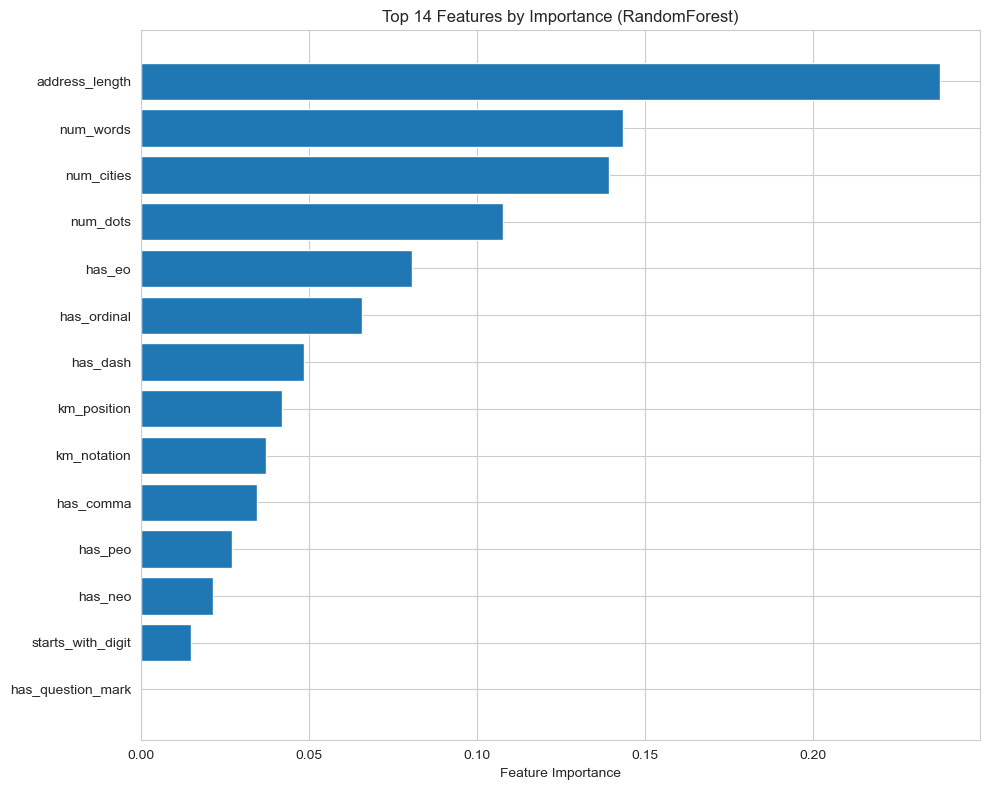

Feature importance apothikefthike sto: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/feature_importance.csv
Trained RandomForest model saved to: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/rf_best_model.joblib


In [48]:
print("\nAnalysi simantikotitas features...")

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_  # *** CHANGED to RF ***
}).sort_values('importance', ascending=False)

print("\nTop 10 simantikoteres features:")
print(feature_importance.head(10).to_string(index=False))

# Plot top 15 features
top_n = min(15, feature_importance.shape[0])
top_features = feature_importance.head(top_n).iloc[::-1]  # reverse for horizontal bar

plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Features by Importance (RandomForest)')
plt.tight_layout()
plt.show()

# Save feature importance to CSV/Excel
FEATURE_IMP_OUT = os.path.join(BASE_OUTPUT_DIR, 'feature_importance.csv')
feature_importance.to_csv(FEATURE_IMP_OUT, index=False)
print(f"Feature importance apothikefthike sto: {FEATURE_IMP_OUT}")

# Save trained RandomForest model
MODEL_OUT = os.path.join(BASE_OUTPUT_DIR, 'rf_best_model.joblib')
joblib.dump(rf, MODEL_OUT)
print(f"Trained RandomForest model saved to: {MODEL_OUT}")


Plot confusion matrix kai classification report...


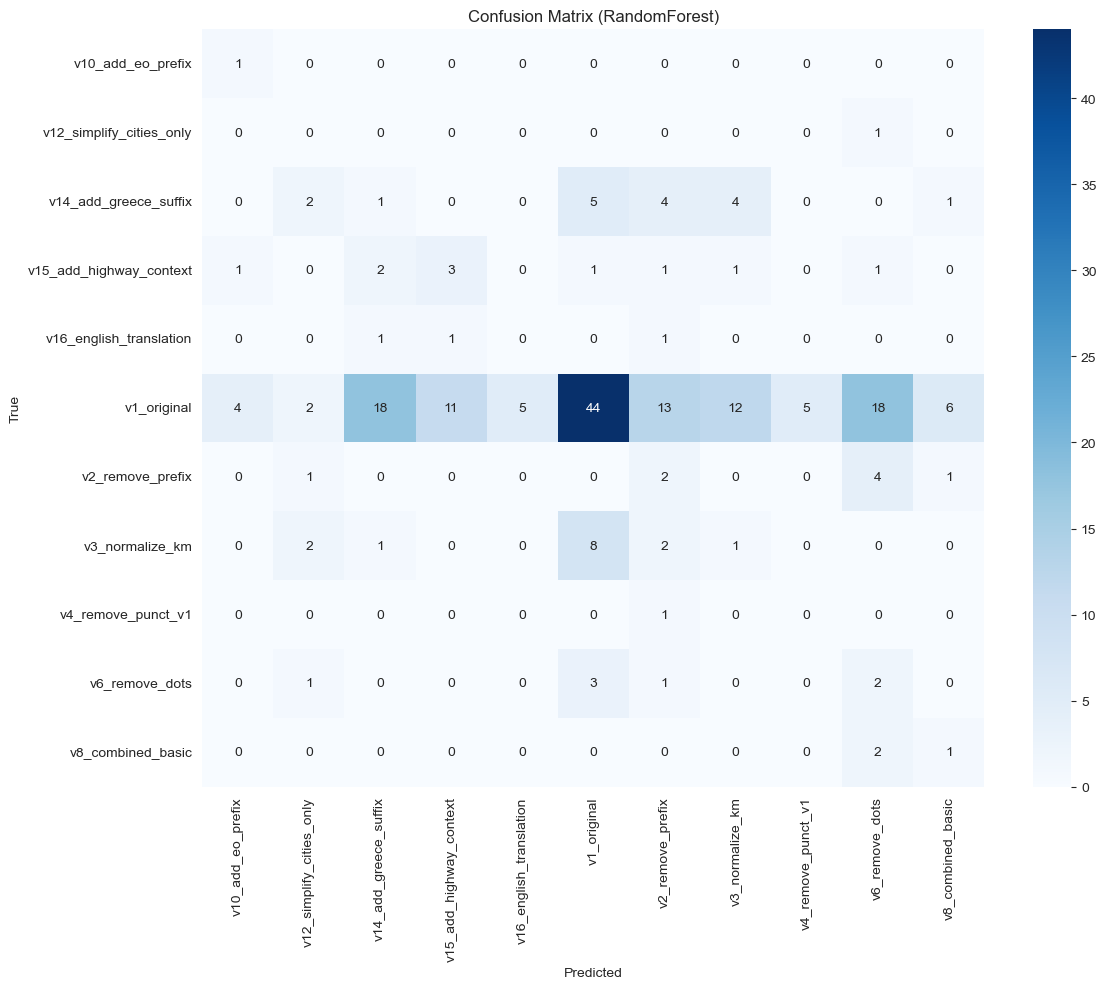

Confusion matrix apothikefthike sto: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/confusion_matrix.csv
Classification report apothikefthike sto: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/classification_report.csv

Classification report (text):
                          precision    recall  f1-score   support

       v10_add_eo_prefix       0.17      1.00      0.29         1
v12_simplify_cities_only       0.00      0.00      0.00         1
   v14_add_greece_suffix       0.04      0.06      0.05        17
 v15_add_highway_context       0.20      0.30      0.24        10
 v16_english_translation       0.00      0.00      0.00         3
             v1_original       0.72      0.32      0.44       138
        v2_remove_prefix       0.08      0.25      0.12         8
         v3_normalize_km       0.06      0.07      0.06        14
      v4_remove_punct_v1       0.00      0.00      0.00         1
          v6_rem

In [46]:
print("\nPlot confusion matrix kai classification report...")

labels = list(rf.classes_)  # *** CHANGED to rf.classes_ ***
cm = confusion_matrix(y_test, y_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (RandomForest)')
plt.tight_layout()
plt.show()

# Save confusion matrix and classification report
CM_OUT = os.path.join(BASE_OUTPUT_DIR, 'confusion_matrix.csv')
cm_df.to_csv(CM_OUT)
print(f"Confusion matrix apothikefthike sto: {CM_OUT}")

CLF_REPORT = classification_report(y_test, y_pred, output_dict=True)
clf_report_df = pd.DataFrame(CLF_REPORT).transpose()
REPORT_OUT = os.path.join(BASE_OUTPUT_DIR, 'classification_report.csv')
clf_report_df.to_csv(REPORT_OUT)
print(f"Classification report apothikefthike sto: {REPORT_OUT}")

print("\nClassification report (text):")
print(classification_report(y_test, y_pred))

In [47]:
print("\nApothikefsi features dataframe kai provlepseis...")

# Add predictions and probabilities to a results dataframe
X_test_reset = X_test.copy().reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

y_test_pred = pd.Series(y_pred, name='predicted_method')
proba = rf.predict_proba(X_test) if hasattr(rf, "predict_proba") else None

results_ml = pd.concat([X_test_reset, y_test_reset.rename('true_method'), y_test_pred], axis=1)

if proba is not None:
    proba_df = pd.DataFrame(proba, columns=[f'prob_{c}' for c in rf.classes_])
    results_ml = pd.concat([results_ml, proba_df.reset_index(drop=True)], axis=1)

ML_RESULTS_OUT = os.path.join(BASE_OUTPUT_DIR, 'ml_results_test_set.xlsx')
results_ml.to_excel(ML_RESULTS_OUT, index=False)
print(f"ML test set results saved to: {ML_RESULTS_OUT}")

# Save features_df (all samples) as well
FEATURES_OUT = os.path.join(BASE_OUTPUT_DIR, 'features_all_samples.xlsx')
features_df.to_excel(FEATURES_OUT, index=False)
print(f"Features dataframe saved to: {FEATURES_OUT}")


Apothikefsi features dataframe kai provlepseis...
ML test set results saved to: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/ml_results_test_set.xlsx
Features dataframe saved to: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/features_all_samples.xlsx


In [37]:
print("\nElenxos corrected_df kai apothikefsi me apotelesmata...")

# Ensure best_distance and original_distance are numeric and finite
corrected_df['best_distance'] = pd.to_numeric(corrected_df['best_distance'], errors='coerce')
corrected_df['original_distance'] = pd.to_numeric(corrected_df['original_distance'], errors='coerce')

# Replace infinite or NaN distances with a large number or NaN handling
corrected_df.loc[~np.isfinite(corrected_df['best_distance']), 'best_distance'] = np.nan
corrected_df.loc[~np.isfinite(corrected_df['original_distance']), 'original_distance'] = np.nan

# Compute improvement safely
corrected_df['improvement_m'] = corrected_df['original_distance'] - corrected_df['best_distance']
corrected_df['improvement_pct'] = np.where(
    (corrected_df['original_distance'].notna()) & (corrected_df['original_distance'] > 0),
    (corrected_df['improvement_m'] / corrected_df['original_distance']) * 100,
    np.nan
)

# Summary stats with safeguards
mean_impr = corrected_df['improvement_pct'].mean(skipna=True)
mean_orig = corrected_df['original_distance'].mean(skipna=True)
mean_best = corrected_df['best_distance'].mean(skipna=True)

print(f"\nMesi veltiosi: {mean_impr:.1f}%")
print(f"Mesi apostasi original: {mean_orig:.1f} m")
print(f"Mesi apostasi corrected: {mean_best:.1f} m")

# Save corrected df (overwrite or new file)
CORRECTED_OUT_SAFE = os.path.join(BASE_OUTPUT_DIR, 'geocoding_corrected_baseline_safe.xlsx')
corrected_df.to_excel(CORRECTED_OUT_SAFE, index=False)
print(f"Corrected baseline (safe) saved to: {CORRECTED_OUT_SAFE}")


Elenxos corrected_df kai apothikefsi me apotelesmata...

Mesi veltiosi: -261.7%
Mesi apostasi original: 6205.6 m
Mesi apostasi corrected: 8704.0 m
Corrected baseline (safe) saved to: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/geocoding_corrected_baseline_safe.xlsx
